# About
In this notebook, we practice model training for a linear regression model and study the `autograd` mechanism, following **chapter 3** in the book *Deep learning with PyTorch: a quick start guide*

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(666)

##### Build our linear regression model

In [3]:
# define the model subclass
class MyLinearModel(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = nn.Linear(dim_in,dim_out)
        
    def forward(self,x):
        return self.linear(x)
    
model = MyLinearModel(2,1) # make the instance of the model class
print(model)

MyLinearModel(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In the above we build a linear regression model $y=\mathbf{w}^T \mathbf{x} + b$ were output $y,b\in\mathbb{R}$, input $\mathbf{x}\in\mathbb{R}^2$ and weight vector $\mathbf{w}\in\mathbb{R}^2$

We can check if the parameter size of our built model fits the theoretical counterpart:

In [4]:
for para in model.parameters():
    print(para)
    print(para.size())

Parameter containing:
tensor([[-0.2660, -0.3251]], requires_grad=True)
torch.Size([1, 2])
Parameter containing:
tensor([-0.5490], requires_grad=True)
torch.Size([1])


In [5]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: linear.weight | Size: torch.Size([1, 2]) | Values : tensor([[-0.2660, -0.3251]], grad_fn=<SliceBackward>) 

Layer: linear.bias | Size: torch.Size([1]) | Values : tensor([-0.5490], grad_fn=<SliceBackward>) 



##### Train the model (estimate the parameters, i.e., weight and bias)

In [6]:
# use a simpler model whose input and output are scalars, this is to make the following computing example more simpler
model_2 = MyLinearModel(1,1)
print(model_2)

# make some data pairs
x_train = torch.randn(10,1)
# x_train = torch.arange(10,dtype=torch.float).reshape(-1,1)+1
y_train = 3*x_train+2. # so that true parameters is weight=3 and bias=2

n_train = torch.normal(0,0.2,size=(10,1)) # let's make some random pertubation to be added to the desired output
y_train = y_train.add(n_train)


# x_train = torch.tensor([[1.6],[2.1],[1.3],[4.8],[3.5]], dtype=torch.float).reshape(-1,1)
# y_train = torch.tensor([[0],[0],[0],[1],[1]], dtype=torch.float).reshape(-1,1) 

print(x_train)
print(y_train)
# x_batches = data.DataLoader(x_train,batch_size=4)

MyLinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
tensor([[ 0.9246],
        [ 1.1853],
        [ 0.9537],
        [ 0.3999],
        [ 0.2945],
        [ 1.8692],
        [ 0.0815],
        [-0.0594],
        [ 0.7523],
        [-0.2576]])
tensor([[4.8494],
        [5.5710],
        [4.6325],
        [3.2161],
        [2.7331],
        [8.0044],
        [2.1698],
        [1.7032],
        [4.3893],
        [1.1482]])


##### Remark
Since we only have limited training data pairs `x_train` and `y_train`, so in the following we use a relatively large epoch number. In this way, it is equivalent to evaluate the gradients using all of the data and then iterate over epochs, which is same as the concept of **batch training with full gradient descent** whereathe difference is that here our dataset for computing gradients is quite small. (Alternatively, one can "generate" enough amount of training data, and apply *mini-batch* SGD).

Note further that, in the following we implement an optimizer using SGD **with nesterov momentum** for accelerated training. We used a learning rate of $0.001$ which seems slow, however, augmented by the nesterov momentum, this optimizer can lead to a convergence nearly as fast as the one obtained by using a (much larger) learning rate of $0.01$ but without any momentum. 

In [7]:
# setup the loss and optimizer
optimizer = optim.SGD(model_2.parameters(),lr=1e-3,momentum=0.9,nesterov=True) # SGD with nesterov momentum
# optimizer = optim.SGD(model_2.parameters(),lr=1e-2) # vanilla SGD without momentum
cost = nn.MSELoss()

# setup the training device
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

# setup the total epoch number
epochs = 2000

# define a function for model training
def TrainLinearModel(model,inputs, labels, loss, optimizer, epochs, device):
    model.to(device)
    inputs.to(device)
    labels.to(device)
    loss_track=torch.tensor([])
    for epoch in range(epochs):
        optimizer.zero_grad() # this is to clear the accumulated gradients for every epoch
        outputs = model_2(inputs)
        loss = cost(outputs,labels)
        loss.backward()
        optimizer.step() # this is wehere SGD updates the estimates of weights
        loss_track = torch.cat((loss_track,loss.unsqueeze(0))) # append latest loss after model update
    return loss_track

# call the model traning function and get the loss records over epochs
loss = TrainLinearModel(model=model_2,inputs=x_train,labels=y_train,loss=cost,optimizer=optimizer,epochs=epochs,device=device)

<div class="alert alert-info"><h4>Caution</h4><p>
1. We can only obtain the ``grad`` properties for the leaf nodes of the computational graph, which have ``requires_grad`` property set to ``True``. For all other nodes in our graph, gradients will not be available.
<br>    
2. We can only perform gradient calculations using ``backward`` once on a given graph, for performance reasons. If we need to do several ``backward`` calls on the same graph, we need to pass ``retain_graph=True`` to the ``backward`` call.
</p></div>

##### Show the training result

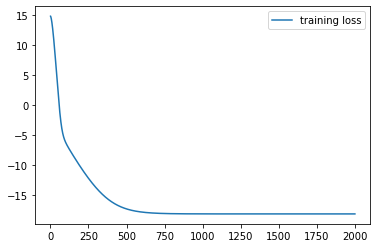

In [8]:
# visualize the learning process
x=torch.arange(epochs)+1
y=loss.detach()
# print(x.size())
# print(y.size())
plt.plot(x.squeeze(),10*y.log10().squeeze(),label='training loss')
plt.legend()
plt.show()

##### Compare with the ground truth
Show and compare the learned parameters, recall that our theoretical model is $y=3x+2$. The learned parameter `linear.weight` is now $2.9947$, and the learned bias `linear.bias` is now $1.9942$ which is almost the same as the true parameters. 

In [9]:
for name, param in model_2.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: linear.weight | Size: torch.Size([1, 1]) | Values : tensor([[3.1864]], grad_fn=<SliceBackward>) 

Layer: linear.bias | Size: torch.Size([1]) | Values : tensor([1.8840], grad_fn=<SliceBackward>) 



In [10]:
# save the trained model
torch.save(model_2.state_dict(),'./my-models/simple-linear-model.pt')

In [11]:
print(model_2.state_dict())

OrderedDict([('linear.weight', tensor([[3.1864]])), ('linear.bias', tensor([1.8840]))])


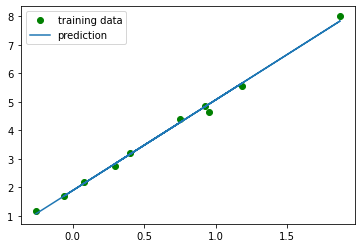

In [12]:
with torch.no_grad():
    plt.plot(x_train,y_train,'go',label='training data')
    plt.plot(x_train,model_2(x_train).numpy(),label='prediction')
    plt.legend()
    plt.show

##### Using `torch.no_grad()`
In the above example, after we have trained our model, using it to do forward pass prediction only, we no longer need to track the computation history for gradient computing, so in the syntax `plt.plt()` we can use `.detach()` for `model_2` to achieve this. Alternativley, we can use `with torch.no_grad():` environment.